In [25]:
from scipy.ndimage import laplace

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [28]:
# Set the path to your dataset folder in Google Drive
dataset_path = "/content/drive/MyDrive/Training"

In [29]:

from skimage import exposure
from scipy.ndimage import gaussian_filter
from keras.preprocessing.image import ImageDataGenerator

In [30]:
# Set the target size for image resizing
target_size = (224, 224)

# Batch size for processing images
batch_size = 32

# Initialize empty lists to store images and labels
images = []
labels = []

In [31]:
# Loop through each tumor type folder
for tumor_type in os.listdir(dataset_path):
    tumor_type_path = os.path.join(dataset_path, tumor_type)

    # Loop through each image in the tumor type folder
    for image_file in os.listdir(tumor_type_path):
        image_path = os.path.join(tumor_type_path, image_file)

        # Read the image using OpenCV and resize it to the target size
        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)

        # Apply the Laplacian filter
        img = exposure.rescale_intensity(img, in_range='image', out_range='dtype')
        img = laplace(img)

        # Append the original image and label to the lists
        images.append(img)
        labels.append(tumor_type)

        # Check if the batch size is reached, then apply data augmentation
        if len(images) % batch_size == 0:
            # Data Augmentation
            datagen = ImageDataGenerator(
                horizontal_flip=True,
                rotation_range=20,
                zoom_range=0.2,
                height_shift_range=0.2,
                width_shift_range=0.2,
                shear_range=0.2,
                fill_mode='nearest'
            )

            # Generate augmented images and append them to the lists
            augmented_images = [datagen.random_transform(img) for _ in range(2)]  # Generate 1 augmented image per original
            images.extend(augmented_images)
            labels.extend([tumor_type] * len(augmented_images))

In [32]:
# Convert lists to NumPy arrays for model training
X = np.array(images)
y = np.array(labels)

# Print the shape of X and y to check
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (4982, 224, 224, 3)
Shape of y: (4982,)


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

In [34]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convert labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [36]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the pre-trained ResNet50 model (including the top layers for classification)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model using the ResNet50 base and adding your custom top layers for classification
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Assuming there are 6 classes



In [37]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 23850500 (90.98 MB)
Trainable params: 262788 (1.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [38]:

# Train the model with validation data
history = model.fit(X_train, y_train_encoded, epochs=32, batch_size=16, validation_data=(X_val, y_val_encoded))

Epoch 1/32
250/250 [==============================] - 24s 77ms/step - loss: 0.7065 - accuracy: 0.7443 - val_loss: 0.4742 - val_accuracy: 0.8305
Epoch 2/32
250/250 [==============================] - 18s 72ms/step - loss: 0.4655 - accuracy: 0.8427 - val_loss: 0.4388 - val_accuracy: 0.8375
Epoch 3/32
250/250 [==============================] - 18s 71ms/step - loss: 0.4222 - accuracy: 0.8514 - val_loss: 0.3831 - val_accuracy: 0.8676
Epoch 4/32
250/250 [==============================] - 18s 71ms/step - loss: 0.3653 - accuracy: 0.8733 - val_loss: 0.3416 - val_accuracy: 0.8776
Epoch 5/32
250/250 [==============================] - 16s 63ms/step - loss: 0.3482 - accuracy: 0.8740 - val_loss: 0.3479 - val_accuracy: 0.8776
Epoch 6/32
250/250 [==============================] - 18s 71ms/step - loss: 0.3266 - accuracy: 0.8886 - val_loss: 0.4082 - val_accuracy: 0.8435
Epoch 7/32
250/250 [==============================] - 16s 63ms/step - loss: 0.3034 - accuracy: 0.8954 - val_loss: 0.3246 - val_accuracy:

In [39]:
import matplotlib.pyplot as plt

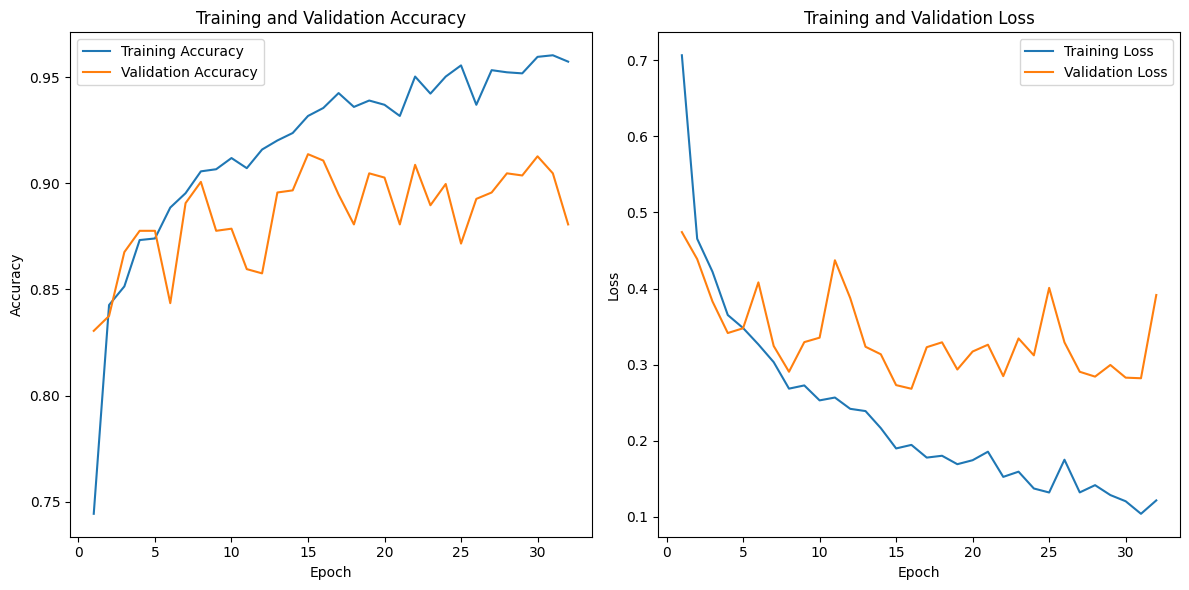

In [40]:
# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [42]:
# Extract features using the CNN model
X_train_features = model.predict(X_train)
X_val_features = model.predict(X_val)

32/32 [==============================] - 3s 89ms/step


In [43]:
# Reshape data for Random Forest
X_train_flatten = X_train_features.reshape(X_train_features.shape[0], -1)
X_val_flatten = X_val_features.reshape(X_val_features.shape[0], -1)

In [44]:
# Initialize Random Forest classifier
random_forest_classifier = RandomForestClassifier(n_estimators=50, random_state=42)

# Train Random Forest classifier
random_forest_classifier.fit(X_train_flatten, y_train_encoded)

# Make predictions on validation set
random_forest_predictions = random_forest_classifier.predict(X_val_flatten)

# Evaluate performance
random_forest_accuracy = metrics.accuracy_score(y_val_encoded, random_forest_predictions)
random_forest_precision = metrics.precision_score(y_val_encoded, random_forest_predictions, average='weighted')
random_forest_recall = metrics.recall_score(y_val_encoded, random_forest_predictions, average='weighted')
random_forest_f1 = metrics.f1_score(y_val_encoded, random_forest_predictions, average='weighted')

# Print results
print("Random Forest (on Vgg19 features): Accuracy = {:.4f}, Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}".format(random_forest_accuracy, random_forest_precision, random_forest_recall, random_forest_f1))

Random Forest (on Vgg19 features): Accuracy = 0.8987, Precision = 0.8994, Recall = 0.8987, F1 Score = 0.8989


In [45]:
from sklearn.neighbors import KNeighborsClassifier


In [46]:
# Initialize k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors as needed

# Train k-NN classifier
knn_classifier.fit(X_train_flatten, y_train_encoded)

# Make predictions on the validation set
knn_predictions = knn_classifier.predict(X_val_flatten)

# Evaluate performance
knn_accuracy = metrics.accuracy_score(y_val_encoded, knn_predictions)
knn_precision = metrics.precision_score(y_val_encoded, knn_predictions, average='weighted')
knn_recall = metrics.recall_score(y_val_encoded, knn_predictions, average='weighted')
knn_f1 = metrics.f1_score(y_val_encoded, knn_predictions, average='weighted')

# Print results for k-NN
print("k-Nearest Neighbors (on vgg19 features): Accuracy = {:.4f}, Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}".format(knn_accuracy, knn_precision, knn_recall, knn_f1))


k-Nearest Neighbors (on vgg19 features): Accuracy = 0.8917, Precision = 0.8927, Recall = 0.8917, F1 Score = 0.8920


In [47]:
from sklearn.ensemble import AdaBoostClassifier


In [48]:
# Initialize AdaBoost classifier with a decision tree base estimator
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train AdaBoost classifier
adaboost_classifier.fit(X_train_flatten, y_train_encoded)

# Make predictions on the validation set
adaboost_predictions = adaboost_classifier.predict(X_val_flatten)

# Evaluate performance
adaboost_accuracy = metrics.accuracy_score(y_val_encoded, adaboost_predictions)
adaboost_precision = metrics.precision_score(y_val_encoded, adaboost_predictions, average='weighted')
adaboost_recall = metrics.recall_score(y_val_encoded, adaboost_predictions, average='weighted')
adaboost_f1 = metrics.f1_score(y_val_encoded, adaboost_predictions, average='weighted')

# Print results for AdaBoost
print("AdaBoost (on vgg19 features): Accuracy = {:.4f}, Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}".format(adaboost_accuracy, adaboost_precision, adaboost_recall, adaboost_f1))


AdaBoost (on vgg19 features): Accuracy = 0.8345, Precision = 0.8591, Recall = 0.8345, F1 Score = 0.8373
